# Time Series Forecasting with LSTM (PyTorch)

This notebook walks through loading a time series from Yahoo Finance, transforming it into supervised windows, training a compact LSTM model to forecast future values, evaluating with common metrics, visualizing results, and saving the trained model. You will also learn how to inspect the model architecture and training logs using `torchinfo`, `torchviz`, and TensorBoard.


## Overview

We build a univariate time‑series forecasting pipeline using PyTorch. The key steps are:

- **Setup & data ingestion:** Install dependencies and fetch a daily closing price series via `yfinance` (or load a CSV).
- **Preprocess:** Split the series into train/validation/test chronologically and scale it to [0, 1].
- **Window the data:** Convert the 1D sequence into sliding windows of `LOOKBACK` timesteps to predict the next `HORIZON` value(s).
- **Define the model:** Implement a small LSTM with a linear head.
- **Train & visualize:** Train the model with early stopping, plot the training curves, and inspect the architecture.
- **Evaluate & forecast:** Compute MAE, RMSE and MAPE on the test set, visualize predictions, and roll the model forward to forecast future values.
- **Save & explore:** Export the trained model and scaler, view the model summary and computation graph, and launch TensorBoard to explore logs.


## Setup & Dependencies

Install and import the core libraries needed for data handling, visualization, and building the LSTM in PyTorch. 

In [1]:
#@title Setup & Dependencies
import sys, os, math, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Auto-install optional deps if missing (for Colab/clean envs)
def _pip(pkg):
    try:
        __import__(pkg.split('==')[0])
    except Exception:
        get_ipython().system('pip -q install ' + pkg)

_pip('yfinance>=0.2.40')
_pip('scikit-learn>=1.3.0')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

## Data Ingestion

Fetch a daily closing‑price series from Yahoo Finance using `yfinance`, or load your own CSV. Only one of the following code cells should be run.


In [2]:
#@title Download a finance series with yfinance (default) { form-width: "50%" }
import yfinance as yf
TICKER = 'AAPL' #@param {type:"string"}
START = '2010-01-01' #@param {type:"string"}
END = ''  # empty = today #@param {type:"string"}
interval = '1d'  # '1d','1wk','1mo'

df = yf.download(TICKER, start=START or None, end=END or None, interval=interval, progress=False)
assert not df.empty, f"No data returned for {TICKER}. Try another ticker or date range."
df = df[['Close']].rename(columns={'Close':'value'})
df.index.name = 'date'
df.head(), df.tail(), df.shape

/tmp/ipykernel_3360/2836307897.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START or None, end=END or None, interval=interval, progress=False)


(Price          value
 Ticker          AAPL
 date                
 2010-01-04  6.424604
 2010-01-05  6.435713
 2010-01-06  6.333344
 2010-01-07  6.321637
 2010-01-08  6.363665,
 Price            value
 Ticker            AAPL
 date                  
 2025-10-01  255.449997
 2025-10-02  257.130005
 2025-10-03  258.019989
 2025-10-06  256.690002
 2025-10-07  256.480011,
 (3965, 1))

In [3]:
# %% Alternative: Load a CSV from the internet (e.g., raw GitHub URL)
# csv_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'  # example
# df = pd.read_csv(csv_url)
# # adapt columns if needed
# if {'Date','Temp'}.issubset(df.columns):
#     df = df.rename(columns={'Date':'date','Temp':'value'})
#     df['date'] = pd.to_datetime(df['date'])
#     df = df.set_index('date')
# df.head(), df.tail(), df.shape

## Train/Val/Test Split & Scaling

Chronologically split the series into training, validation, and test sets (70%/15%/15%) to preserve temporal order. Then scale the values to the [0, 1] range using `MinMaxScaler` so that the LSTM trains more stably.


In [4]:
#@title Split & scale
values = df[['value']].astype('float32').values
n = len(values)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(values[:train_end])
val_scaled   = scaler.transform(values[train_end:val_end])
test_scaled  = scaler.transform(values[val_end:])

len(train_scaled), len(val_scaled), len(test_scaled)

(2775, 595, 595)

## Windowing the Series

Transform the 1D time series into supervised learning samples. Each sample consists of a window of `LOOKBACK` past values and the next `HORIZON` value(s) as targets. This function creates the input/output arrays needed for training.


In [5]:
#@title Window utilities
from typing import Tuple

def make_windows(arr: np.ndarray, lookback: int, horizon: int) -> Tuple[np.ndarray, np.ndarray]:
    X, y = [], []
    for i in range(len(arr) - lookback - horizon + 1):
        X.append(arr[i : i+lookback])
        y.append(arr[i+lookback : i+lookback+horizon])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

LOOKBACK = 60   #@param {type:"integer"}
HORIZON  = 1    #@param {type:"integer"}

X_train, y_train = make_windows(train_scaled, LOOKBACK, HORIZON)
X_val,   y_val   = make_windows(val_scaled, LOOKBACK, HORIZON)
X_test,  y_test  = make_windows(test_scaled, LOOKBACK, HORIZON)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2715, 60, 1),
 (2715, 1, 1),
 (535, 60, 1),
 (535, 1, 1),
 (535, 60, 1),
 (535, 1, 1))

### Dataset & DataLoader

Wrap the windowed arrays into a PyTorch `Dataset` and `DataLoader` so batches can be fed into the model during training and evaluation.


In [6]:
#@title Dataset & DataLoader
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 64  #@param {type:"integer"}
train_ds = SeqDataset(X_train, y_train)
val_ds   = SeqDataset(X_val, y_val)
test_ds  = SeqDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

len(train_ds), len(val_ds), len(test_ds)

(2715, 535, 535)

## Define the Model

Build a lightweight LSTM network with a configurable number of layers and hidden units. A linear layer on top projects the final hidden state to the desired forecast horizon.


In [7]:
#@title LSTM model
class LSTMForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.1, horizon=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.head = nn.Linear(hidden_size, horizon)
    def forward(self, x):
        # x: (B, T, 1)
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last)

model = LSTMForecaster(horizon=HORIZON).to(DEVICE)
sum(p.numel() for p in model.parameters())

50497

### Model Visualization

After defining the model, use two optional tools to inspect its architecture:

1. **`torchinfo` summary** – prints a table of each layer with output shapes and parameter counts.
2. **`torchviz` computation graph** – renders a PNG of the forward computation graph.

If these tools are not already installed, the first code cell below will install them.


In [9]:
#@title Install visualizers
try:
    import torchinfo  # noqa: F401
    from torchviz import make_dot  # noqa: F401
except Exception:
    # Colab/clean envs
    import sys
    !pip -q install torchinfo torchviz graphviz
    import torchinfo
    from torchviz import make_dot

from IPython.display import display, Image
from pathlib import Path
import torch
import pandas as pd

artifacts = Path('artifacts'); artifacts.mkdir(exist_ok=True)

In [10]:
#@title torchinfo summary (table view)
from torchinfo import summary

assert 'model' in globals(), 'Model not found. Run the model definition cell first.'
assert 'LOOKBACK' in globals(), 'LOOKBACK not found.'

s = summary(model, input_size=(1, LOOKBACK, 1),
            col_names=("kernel_size","num_params","mult_adds","trainable"),
            depth=6, verbose=0)
print(s)

Layer (type:depth-idx)                   Kernel Shape              Param #                   Mult-Adds                 Trainable
LSTMForecaster                           --                        --                        --                        True
├─LSTM: 1-1                              --                        50,432                    3,025,920                 True
├─Linear: 1-2                            --                        65                        65                        True
Total params: 50,497
Trainable params: 50,497
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.20
Estimated Total Size (MB): 0.23


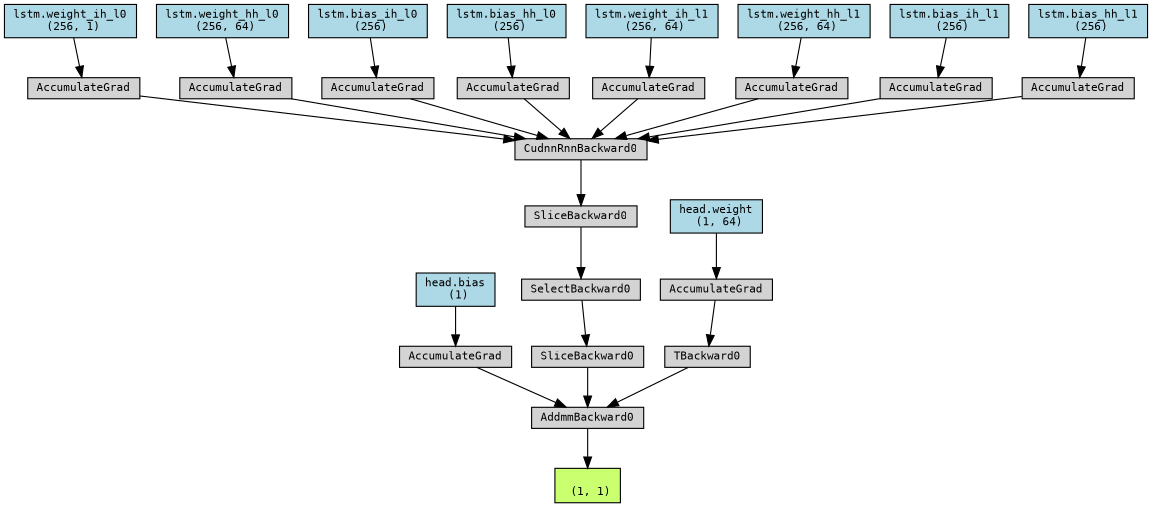

In [11]:
#@title torchviz computation graph (PNG)
assert 'model' in globals(), 'Model not found. Run the model definition cell first.'
assert 'LOOKBACK' in globals(), 'LOOKBACK not found.'
assert 'DEVICE' in globals(), 'DEVICE not found.'

model.eval()
dummy = torch.randn(1, LOOKBACK, 1, device=DEVICE)
out = model(dummy)
dot = make_dot(out, params=dict(model.named_parameters()))
dot.format = 'png'
png_path = str((artifacts / 'model_graph').resolve())
dot.render(png_path, cleanup=True)
display(Image(filename=png_path + '.png'))

## Training

Train the LSTM using mean squared error (MSE) loss, the AdamW optimizer, and a cosine learning rate scheduler. Early stopping monitors the validation loss to prevent overfitting.


In [12]:
#@title Train loop with early stopping
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

EPOCHS = 50  #@param {type:"integer"}
LR = 1e-3    #@param {type:"number"}
PATIENCE = 7 #@param {type:"integer"}

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(EPOCHS, 10))

best_loss = float('inf')
best_state = None
pat = 0
train_hist, val_hist = [], []

for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_dl:
        xb = xb.to(DEVICE)
        yb = yb.squeeze(-1).to(DEVICE)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_ds)
    train_hist.append(epoch_loss)

    model.eval()
    with torch.no_grad():
        vloss = 0.0
        for xb, yb in val_dl:
            xb = xb.to(DEVICE)
            yb = yb.squeeze(-1).to(DEVICE)
            preds = model(xb)
            loss = criterion(preds, yb)
            vloss += loss.item() * xb.size(0)
        vloss /= len(val_ds)
        val_hist.append(vloss)

    scheduler.step()
    if vloss < best_loss:
        best_loss = vloss
        best_state = model.state_dict()
        pat = 0
    else:
        pat += 1
    if (epoch % 5) == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train {epoch_loss:.5f} | val {vloss:.5f} | lr {scheduler.get_last_lr()[0]:.2e}")
    if pat >= PATIENCE:
        print(f"Early stopping at epoch {epoch}")
        break

if best_state is not None:
    model.load_state_dict(best_state)
else:
    print("Warning: best_state was None; using last epoch state.")

Epoch 001 | train 0.02965 | val 0.05431 | lr 9.99e-04
Epoch 005 | train 0.00028 | val 0.01494 | lr 9.76e-04
Epoch 010 | train 0.00022 | val 0.00705 | lr 9.05e-04
Epoch 015 | train 0.00023 | val 0.00209 | lr 7.94e-04
Epoch 020 | train 0.00020 | val 0.00645 | lr 6.55e-04
Epoch 025 | train 0.00021 | val 0.00318 | lr 5.00e-04
Epoch 030 | train 0.00019 | val 0.00348 | lr 3.45e-04
Epoch 035 | train 0.00018 | val 0.00309 | lr 2.06e-04
Early stopping at epoch 35


### Visualize Training History

Plot the training and validation loss curves across epochs to see how the model converges and when early stopping is triggered.


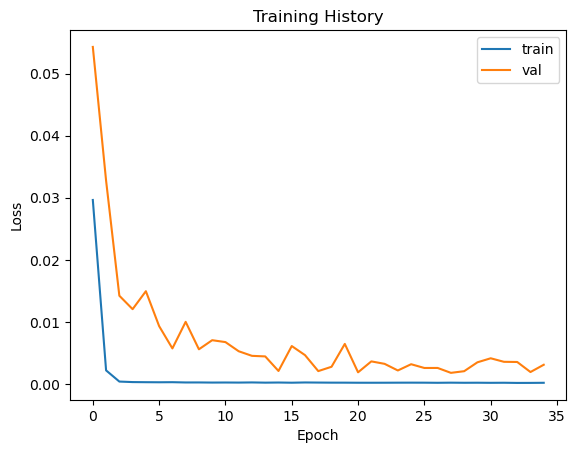

In [13]:
#@title Plot training curves
plt.figure()
plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training History')
plt.show()

### Explore Training Logs with TensorBoard

This cell logs the actual training and validation losses collected in `train_hist` and `val_hist` during the LSTM training run. It then launches TensorBoard so you can interactively explore the loss curves and other metrics.


In [14]:
# Proxy-aware TensorBoard launcher (works on JupyterHub/JupyterLab)
# Log the actual training and validation losses collected during the LSTM training run
from torch.utils.tensorboard import SummaryWriter

logdir = "runs/lstm_training"
writer = SummaryWriter(logdir)
# Write training and validation losses
for epoch, (train_loss, val_loss) in enumerate(zip(train_hist, val_hist)):
    writer.add_scalar("Loss/train", float(train_loss), epoch)
    writer.add_scalar("Loss/val", float(val_loss), epoch)
writer.close()

# Start TensorBoard on a free port and embed via the hub prefix
import os, re
from tensorboard import program
from IPython.display import HTML

tb = program.TensorBoard()
tb.configure(argv=[None, "--logdir", logdir, "--load_fast=false", "--bind_all", "--port", "0"])
tb_url = tb.launch()                     # e.g. http://127.0.0.1:6007/
print("TensorBoard (direct):", tb_url)

# Construct the proxied URL for JupyterHub/Lab environments
port = re.search(r":(\d+)", tb_url).group(1)
prefix = os.environ.get("JUPYTERHUB_SERVICE_PREFIX", "/")
iframe_url = f"{prefix.rstrip('/')}/proxy/{port}/"   # e.g. /user/<id>/proxy/6007/
HTML(f'<iframe src="{iframe_url}" width="100%" height="620" style="border:0"></iframe>')


TensorBoard (direct): http://notebook-290ea90f-cc3f-4871-9a10-f7eb297d40b9:36619/


/opt/conda/lib/python3.12/site-packages/IPython/core/display.py:474: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Evaluation on Test Set

Invert the scaling on predictions and compute common regression metrics such as MAE, RMSE, and MAPE. If predicting multiple steps, metrics are averaged across steps.


In [15]:
#@title Evaluate on test
model.eval()
preds_list, trues_list = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(DEVICE)
        preds = model(xb).cpu().numpy()          # (B, H)
        trues = yb.squeeze(-1).cpu().numpy()     # (B, H)  <-- squeeze extra dim
        preds_list.append(preds)
        trues_list.append(trues)

preds = np.concatenate(preds_list, axis=0)  # (N, H)
trues = np.concatenate(trues_list, axis=0)  # (N, H)

# invert scaling (works for 2-D (N,H))
def inverse_scale_2d(mat: np.ndarray) -> np.ndarray:
    return np.hstack([scaler.inverse_transform(mat[:, [i]]) for i in range(mat.shape[1])])

preds_inv = inverse_scale_2d(preds)
trues_inv = inverse_scale_2d(trues)

mae = mean_absolute_error(trues_inv.flatten(), preds_inv.flatten())
rmse = mean_squared_error(trues_inv.flatten(), preds_inv.flatten())
mape = np.mean(np.abs((trues_inv - preds_inv) / (np.clip(np.abs(trues_inv), 1e-8, None)))) * 100

print({'MAE': float(mae), 'RMSE': float(rmse), 'MAPE_%': float(mape)})


{'MAE': 23.607059478759766, 'RMSE': 689.4132690429688, 'MAPE_%': 10.935544967651367}


## Visualize Last Window Predictions

Compare the model's predictions with the ground truth on the last few points of the test set to get a feel for forecasting accuracy.


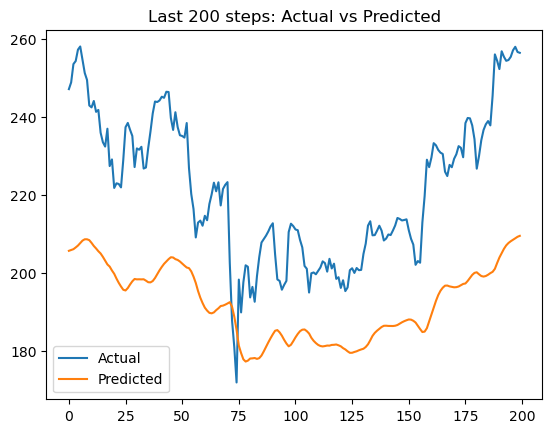

In [16]:
#@title Plot predictions vs actuals (tail)
k = 200  #@param {type:"integer"}
plt.figure()
plt.plot(trues_inv.flatten()[-k:], label='Actual')
plt.plot(preds_inv.flatten()[-k:], label='Predicted')
plt.legend()
plt.title(f'Last {k} steps: Actual vs Predicted')
plt.show()

## Multi-step Forecasting

Roll the model forward by repeatedly feeding its own predictions back into the input window. This allows forecasting several steps into the future.


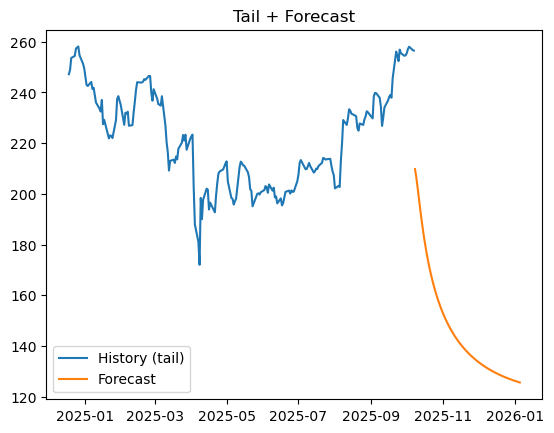

In [17]:
#@title Forecast next steps (business/day-aware + adjustable length)
FORECAST_STEPS = 90  # make it longer if you want

series_scaled = scaler.transform(values)
context = series_scaled[-LOOKBACK:].copy()
outs = []

model.eval()
with torch.no_grad():
    for _ in range(FORECAST_STEPS):
        xb = torch.tensor(context[None, :, :], dtype=torch.float32, device=DEVICE)
        pred = model(xb).cpu().numpy()[0]
        step = pred[-1] if HORIZON > 1 else pred[0]
        outs.append(step)
        context = np.concatenate([context[1:], np.array([[step]], dtype=np.float32)], axis=0)

forecast = scaler.inverse_transform(np.array(outs).reshape(-1, 1)).flatten()

# use the series' actual time step (handles business days)
delta = df.index[-1] - df.index[-2]
future_index = pd.date_range(df.index[-1] + delta, periods=FORECAST_STEPS, freq=delta)

plt.figure()
plt.plot(df.index[-200:], df.value[-200:], label='History (tail)')
plt.plot(future_index, forecast, label='Forecast')
plt.title('Tail + Forecast')
plt.legend()
plt.show()


## Save Artifacts

Persist the trained model and the scaler to disk so that you can reload them later for inference without retraining.


In [18]:
#@title Export model & scaler
out_dir = Path('artifacts'); out_dir.mkdir(exist_ok=True)
model_path = out_dir / 'lstm_forecaster.pt'
scaler_path = out_dir / 'scaler.pkl'
torch.save({'state_dict': model.state_dict(), 'hparams': {'lookback': LOOKBACK, 'horizon': HORIZON}}, model_path)
import pickle
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
model_path, scaler_path

(PosixPath('artifacts/lstm_forecaster.pt'), PosixPath('artifacts/scaler.pkl'))

## Notes
- Switch to a different ticker or interval for other time scales.
- For multiple features (e.g., OHLCV), expand input_size and adapt the scaler.
- For seasonality, consider adding Fourier terms or using `Prophet`/`SARIMAX` for baselines.
- For long contexts, try `Temporal Convolutional Networks` or `Transformer` variants.
